### Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта
1.Загрузите данные и выполните их ресемплирование по одному часу.

2.Проанализируйте данные.

3.Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

4.Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных
Данные лежат в файле taxi.csv. Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.sort_index(inplace=True)
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df.index.year.value_counts()

2018    26496
Name: datetime, dtype: int64

Все данные за 2018 год, поэтому год в параметры включать необязательно.

In [7]:
#Ресемплируем данные с интервалом в 1 час
df = df.resample('1H').sum()
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

In [8]:
#определим тренды и сезонность
decomposed_week = seasonal_decompose(df['2018-03-05':'2018-03-12'])
decomposed_month = seasonal_decompose(df.resample('1D').sum()['2018-03-05':'2018-04-02'])

In [9]:
def trend_seasonality(decomposed):
    plt.figure(figsize=(8, 10))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

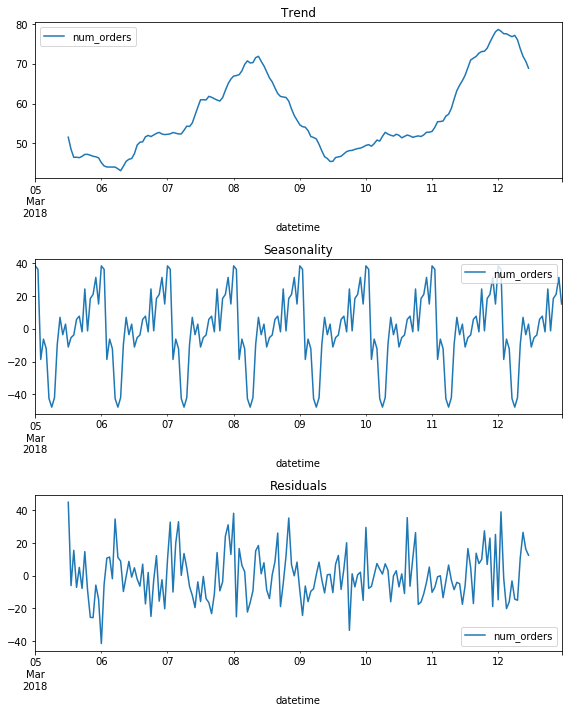

In [10]:
trend_seasonality(decomposed_week)

Наибольшее число заказов поступает в четверг и в понедельник. А во вторник и в субботу заказов мало. 

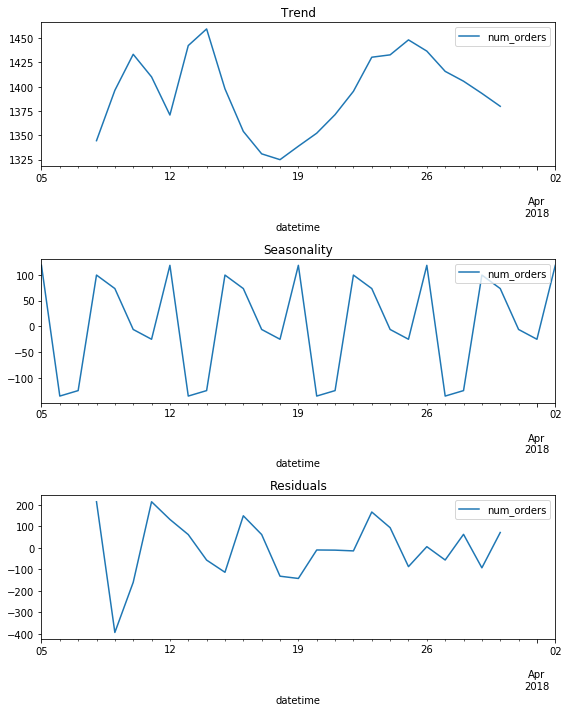

In [11]:
trend_seasonality(decomposed_month)

# 3. Обучение

In [12]:
#создадим признаки
def make_features(df,max_lag, rolling_mean_size):
    #df['month'] = df.index.month
    #df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(lag)]  = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


In [13]:
make_features(df, 20, 20)

In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [15]:
#def gscv(model, parameters):
 #   grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 3, n_jobs=None)
  #  grid.fit(features_train,target_train, verbose=100)    
    # Results from Grid Search
   # print("\n========================================================")
   # print(" Результаты Grid Search " )
   # print("========================================================")    
    
   # print("\n The best estimator across ALL searched params:\n",
   #           grid.best_estimator_)
    
   # print("\n The best score across ALL searched params:\n",
    #          grid.best_score_)
    
   # print("\n The best parameters across ALL searched params:\n",
   #           grid.best_params_)
    
   # print("\n ========================================================")   
def gscv(model, parameters):
    tscv = TimeSeriesSplit(n_splits=8) # 1/(8+1) * 90% = 10% размеры тестовой и валидационной выборки
    gsearch = GridSearchCV(model, param_grid=parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
    

In [16]:
model_catboost = CatBoostRegressor()
parameters_catboost = {'depth'         : [8, 10],
                       'learning_rate' : [0.1, 0.3],
                       'iterations'    : [500,700]
                      }
gscv(model_catboost, parameters_catboost)

In [17]:
%%time
model_cat=CatBoostRegressor(depth=8,
                        iterations=500,
                        learning_rate=0.1,
                        loss_function='RMSE').fit(features_train,target_train,verbose=100)
train_predict_cat=model_cat.predict(features_train)
test_predict_cat = model_cat.predict(features_test)
rmse_train=mean_squared_error(train_predict_cat,target_train)
rmse_test=mean_squared_error(test_predict_cat,target_test)
print('RMSE обучающей выборки: ',np.sqrt(rmse_train))
print('RMSE тестовой выборки: ',np.sqrt(rmse_test))

0:	learn: 36.9203405	total: 55.6ms	remaining: 27.7s
100:	learn: 17.6814892	total: 5.12s	remaining: 20.2s
200:	learn: 13.6305272	total: 10.4s	remaining: 15.4s
300:	learn: 10.7847848	total: 15.7s	remaining: 10.4s
400:	learn: 8.6917803	total: 20.9s	remaining: 5.15s
499:	learn: 7.1405152	total: 26.1s	remaining: 0us
RMSE обучающей выборки:  7.1405151836099625
RMSE тестовой выборки:  43.521205934699935
CPU times: user 24.4 s, sys: 1.99 s, total: 26.3 s
Wall time: 27.9 s


In [18]:
%%time

model_lin=LinearRegression(n_jobs=-1).fit(features_train,target_train)
train_predict_lin=model_lin.predict(features_train)
test_predict_lin = model_lin.predict(features_test)
rmse_train=mean_squared_error(train_predict_lin,target_train)
rmse_test=mean_squared_error(test_predict_lin,target_test)
print('RMSE обучающей выборки: ',np.sqrt(rmse_train))
print('RMSE тестовой выборки: ',np.sqrt(rmse_test))


RMSE обучающей выборки:  29.921800885810278
RMSE тестовой выборки:  51.471601059129135
CPU times: user 20.3 ms, sys: 109 ms, total: 130 ms
Wall time: 20.8 ms


In [19]:
model_lgbm = LGBMRegressor()
parameters_lgbm = {'depth'         : [8, 10],
                   'learning_rate' : [0.1, 0.3],
                   'iterations'    : [500,700]
                  }
gscv(model_lgbm, parameters_lgbm)
 

In [20]:
%%time
model_lgbm=LGBMRegressor(depth=8,
                        iterations=500,
                        learning_rate=0.1,
                        n_estimators=300,
                          num_leaves=12,
                          objective='regression').fit(features_train,target_train)
train_predict_lgbm=model_lgbm.predict(features_train)
test_predict_lgbm = model_lgbm.predict(features_test)
rmse_train=mean_squared_error(train_predict_lgbm,target_train)
rmse_test=mean_squared_error(test_predict_lgbm,target_test)
print('RMSE обучающей выборки: ',np.sqrt(rmse_train))
print('RMSE тестовой выборки: ',np.sqrt(rmse_test))


RMSE обучающей выборки:  12.871025308472893
RMSE тестовой выборки:  42.916345508638685
CPU times: user 1.87 s, sys: 26.4 ms, total: 1.89 s
Wall time: 1.89 s


# 4. Вывод

Модель LGBMRegressor дала лучший результат RMSE на тестовой выборке 46.9. CatBoostRegressor оказалась чуть хуже RMSE = 49.28. Самый худший результат у линейной регрессии RMSE = 55.23.

После поправок значения метрики RMSE улучшилось. RMSE LGBMRegressor на тестовой выборке 42.9,  RMSE CatBoostRegressor на тестовой выборке 43.5, RMSE LinearRegression на тестовой выборке 51.4    

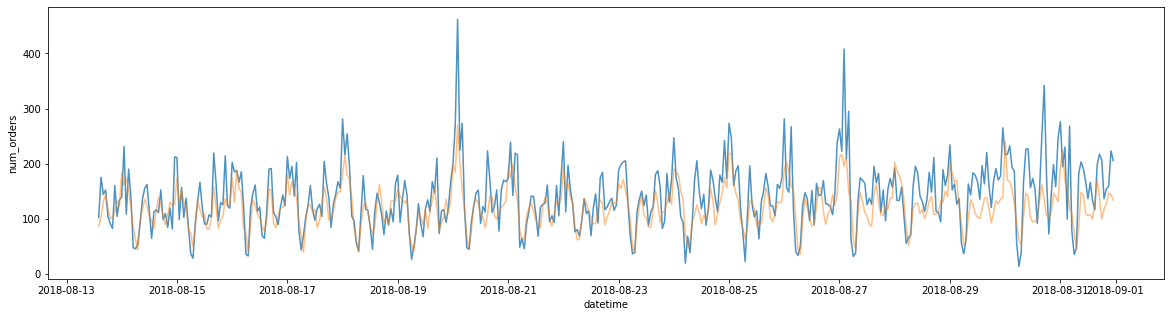

In [21]:
#графики факт/предсказание 

#CatBoostRegressor
plt.figure(figsize=(20, 5))
sns.lineplot(x = target_test.index, \
             y = target_test, alpha = 0.8)
sns.lineplot(x = target_test.index, \
             y = test_predict_cat , alpha = 0.5)
plt.show()

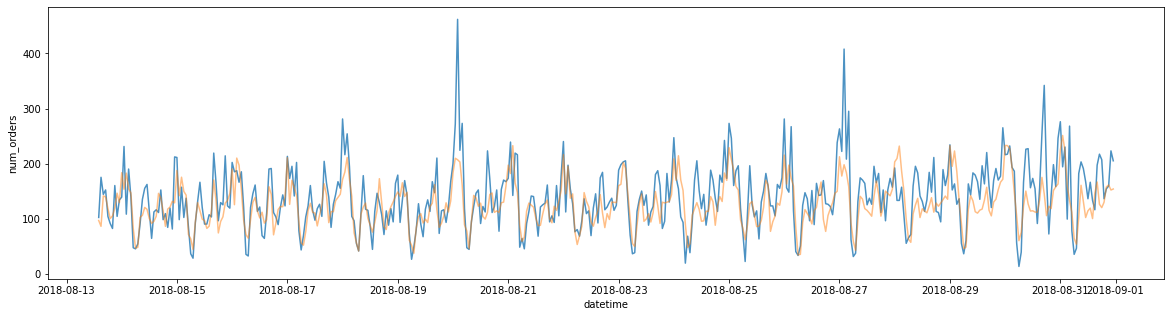

In [22]:
#LGBMRegressor
plt.figure(figsize=(20, 5))
sns.lineplot(x = target_test.index, \
             y = target_test, alpha = 0.8)
sns.lineplot(x = target_test.index, \
             y = test_predict_lgbm , alpha = 0.5)
plt.show()

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48